# Deep Q-Network

#### Prof. Armando Alves Neto - Introdução ao Aprendizado por Reforço - PPGEE/UFMG

<img src="lunar_lander.gif" width="400">

Objetivo: utilizar o algoritmo de DQN para treinar o pouso de uma sonda lunar na posição entre as duas bandeiras.

## Características da sonda lunar:

### Espaço de observações

Espaço de estados com 8 dimensões:
- posições $x$ e $y$ 
- velocidades lineares em $x$ e $y$ 
- ângulo 
- velocidade angular 
- dois contatos (boleanos) representando o contato de cada perna com o chão.

### Espaço de ações

Existem quatro ações possíveis:
- fazer nada
- acionar propulsor de orientação à esquerda
- acionar propulsor principal
- acionar propulsor de orientação à direita

### Função de reforço

Para cada passo, o reforço:
- é aumentado/diminuído quanto mais próximo/mais o módulo de pouso estiver da plataforma de pouso
- é aumentado/diminuído quanto mais lento/mais rápido o módulo de pouso estiver se movendo
- diminui quanto mais o lander é inclinado (ângulo não horizontal)
- é aumentado em 10 pontos para cada perna que está em contato com o solo
- é reduzido em 0,03 pontos a cada quadro que um motor lateral está disparando
- é diminuído em 0,3 pontos a cada quadro que o motor principal está disparando.

O episódio recebe uma recompensa adicional de -100 ou +100 pontos por bater ou pousar com segurança, respectivamente. Um episódio é considerado uma solução se obtiver pelo menos 200 pontos.

### Estados terminais

O episódio termina se:
- a sonda atingir o solo
- a sonda sair do campo de visão (coordenada x maior que 1)
- a sonda para de se mover

Importando bibliotecas.

In [1]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)
from IPython.display import clear_output
from collections import deque, namedtuple
import seaborn as sns
sns.set()

Variáveis globais.

In [2]:
UPDATE_EVERY = 4        # how often to update the network

Cria uma classe (```RunningAverage()```) apenas para calcular a média móvel do sinal de reforço.

In [3]:
class RunningAverage(object):
    def __init__(self, N):
        self.buffer = deque(maxlen=N)

    def push(self, val):  
        self.buffer.append(val)

    def get(self):
        return np.mean(self.buffer)

Define arquitetura da rede neural com ```state_size```entradas, ```action_size``` saídas e duas camadas escondidas de tamanho ```hidden```.

In [4]:
class QNetwork(nn.Module):
    ##########################################
    def __init__(self, state_size, action_size, hidden=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, action_size)

    ##########################################
    # Build a network that maps state -> action values.
    def forward(self, state):
        x = F.relu(self.fc1(state))
        action = F.relu(self.fc2(x))
        return self.fc3(action)

Gerenciando o replay buffer. O buffer tem tamanho fixo e armazena tuplas de experiências com o ambiente.

In [5]:
class ReplayBuffer:
    ##########################################
    def __init__(self, parameters, action_size, buffer_size=int(1e5)):
        self.action_size = action_size
        self.batch_size = parameters['batch_size']
        self.memory = deque(maxlen=buffer_size)  
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.device = parameters['device']
    
    ##########################################
    # Add a new experience to memory.
    def add(self, S, A, R, Sl, done):
        e = self.experience(S, A, R, Sl, done)
        self.memory.append(e)
    
    ##########################################
    # Randomly sample a batch of experiences from memory.
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
    
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)
    
    ##########################################
    # Return the current size of internal memory.
    def __len__(self):
        return len(self.memory)

In [6]:
class Agent():
    ##########################################
    def __init__(self, parameters, state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size
        
        # parametros de aprendizado
        self.gamma = parameters['gamma']
        self.alpha = parameters['alpha']
        self.tau = parameters['tau']
        self.batch_size = parameters['batch_size']
        self.device = parameters['device']

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size).to(self.device)
        #self.qnetwork_target = QNetwork(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.alpha)

        # Replay memory
        self.memory = ReplayBuffer(parameters, action_size)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    ##########################################
    def step(self, S, A, R, Sl, done):
        
        # Save experience in replay memory
        self.memory.add(S, A, R, Sl, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    ##########################################
    def act(self, state, eps=0.0):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if np.random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.choice(np.arange(self.action_size))

    ##########################################
    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        #q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets_next = self.qnetwork_local(next_states).detach().max(1)[0].unsqueeze(1)
        
        ### Calculate target value from bellman equation
        q_targets = rewards + self.gamma*q_targets_next * (1 - dones)
        
        ### Calculate expected value from local network
        q_expected = self.qnetwork_local(states).gather(1, actions)

        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        #self.soft_update(self.qnetwork_local, self.qnetwork_target)                     
    
    ##########################################
    # Soft update model parameters. θ_target = τ*θ_local + (1 - τ)*θ_target
    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

In [7]:
class DQN(object):
    def __init__(self, parameters, eps_decay=0.995):
        
        self.parameters = parameters

        # numero de episodios
        self.episode = 0
        self.max_iter = parameters['max_iter']
        
        # parametros de aprendizado
        self.gamma = parameters['gamma']
        self.alpha = parameters['alpha']
        self.device = parameters['device']
        
        # cria ambiente
        self.env = gym.make('LunarLander-v2')
        self.env.seed(0)
        
        self.agent = Agent(parameters, state_size=self.env.observation_space.shape[0], action_size=self.env.action_space.n)
        
        # epsilon decresce ao longo do tempo
        self.eps = parameters['eps']
        self.eps_end = parameters['eps']/100.0
        self.eps_decay = eps_decay

In [8]:
class DQN(DQN):
    def runEpisode(self, print_every=20):
    
        # novo episodio
        self.episode += 1
        
        rewards = []
        
        S = self.env.reset()

        for _ in range(parameters['max_iter']):
            
            A = self.agent.act(S, self.eps)
            Sl, R, done, _ = self.env.step(A)
            rewards.append(R)
            
            self.agent.step(S, A, R, Sl, done)

            if self.episode % print_every == 0:
                self.env.render()

            # proximo estado
            S = Sl
            
            if done:
                break 

        # decrease epsilon
        self.eps = np.max([self.eps_end, self.eps_decay*self.eps])

        return np.sum(np.array(rewards))

Programa principal.

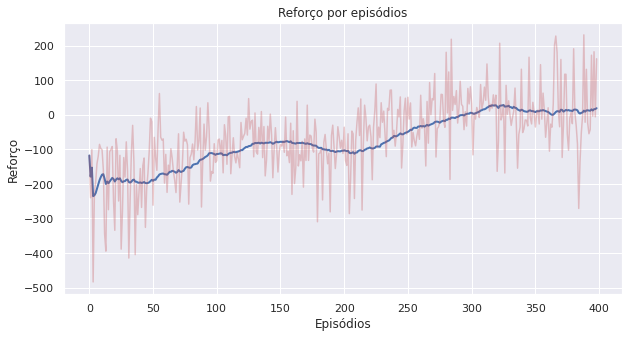

KeyboardInterrupt: 

In [9]:
##########################################
# main
##########################################
if __name__ == '__main__':
    
    plt.ion()

    # cria objeto para calculo da média movel do reward
    avg_calc = RunningAverage(50)
    
    # parametros
    parameters = {'episodes'  : 2000,
                  'max_iter'  : 1000,
                  'gamma'     : 0.99,
                  'eps'       : 1.0e0,
                  'alpha'     : 5.0e-4,
                  'tau'       : 1.0e-3, # for soft update of target parameters
                  'batch_size': 64,     # minibatch size
                  'device'    : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                  }
    
    # historico dos reforços
    rewards = []
    avg_rewards = []
    
    dqn = DQN(parameters)
    
    while dqn.episode <= parameters['episodes']:
        
        # roda um episodio
        total_reward = dqn.runEpisode()

        # rewards
        rewards.append(total_reward)
        # reward medio
        avg_calc.push(total_reward)
        avg_rewards.append(avg_calc.get())

        plt.figure(1)
        clear_output(wait=True)
        plt.clf()
        plt.plot(avg_rewards, 'b', linewidth=2)
        plt.plot(rewards, 'r', alpha=0.3)
        plt.title('Reforço por episódios')
        plt.xlabel('Episódios')
        plt.ylabel('Reforço')

        plt.show()
        plt.pause(.1)

    plt.ioff()